In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
from scipy import stats
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from pycaret.regression import *

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [10]:
# ADD TIME FEATURES
def add_time_features(df, time_column):
    
    df[time_column] = pd.to_datetime(df[time_column])  # Make sure the time column is in datetime format
    
    # Extract various time features
    df['hour'] = df[time_column].dt.hour
    df['day_of_week'] = df[time_column].dt.dayofweek
    df['month'] = df[time_column].dt.month
    df['day_of_year'] = df[time_column].dt.dayofyear
    df['week_of_year'] = df[time_column].dt.isocalendar().week 
    
    return df

In [11]:
# PREPROCESSING
def preprocessing(targets, observed, estimated, test):
   
    # Ensure the datetime columns are in datetime format
    targets['time'] = pd.to_datetime(targets['time'])
    observed['date_forecast'] = pd.to_datetime(observed['date_forecast'])
    estimated['date_forecast'] = pd.to_datetime(estimated['date_forecast'])
    test['date_forecast'] = pd.to_datetime(test['date_forecast'])

    # Resample observed, estimated, and test data to 1 hour using mean() as aggregator
    # and drop rows where all columns are NaN
    observed_resampled = observed.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    test_resampled = test.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    
    # Merge the observed and estimated data
    weather_data = pd.concat([observed_resampled, estimated_resampled])

    # Merge with target values
    merged_data = pd.merge(targets, weather_data, how='inner', left_on='time', right_on='date_forecast')

    # Add the time-based features
    merged_data = add_time_features(merged_data, 'time')  
    test_resampled = add_time_features(test_resampled, 'date_forecast') 
    
    # Drop non-feature columns
    merged_data = merged_data.drop(columns=['time', 'date_forecast', 'pv_measurement'])
    
    return merged_data, test_resampled

In [13]:
from pycaret.regression import *
def process_location(X, y, location_name):
    # Combine feature data and target into a single DataFrame
    data = X.copy()
    data['target'] = y

    # Setup the environment in PyCaret
    exp_reg = setup(data=data, target='target', session_id=123,
                    categorical_features=['dew_or_rime:idx', 'is_day:idx', 'is_in_shadow:idx'],
                    #remove_outliers=True,  #Ble dårligere med denne
                    html=False,
                    #silent=True,  
                    experiment_name=f'exp_{location_name}')

    # Create a LightGBM model
    lightgbm = create_model('lightgbm')

    # Tune the model
    tuned_lightgbm = tune_model(lightgbm)

    # Create a bagged version of the tuned model
    bagged_lightgbm = ensemble_model(tuned_lightgbm, method='Bagging')

    # Finalize the model - this will train it on the complete dataset
    final_model = finalize_model(bagged_lightgbm)

    # Save the model for future use
    save_model(final_model, f'final_model_for_location_{location_name}')

    return final_model

                    Description        Value
0                    Session id          123
1                        Target       target
2                   Target type   Regression
3           Original data shape  (34061, 51)
4        Transformed data shape  (32868, 67)
5   Transformed train set shape  (22649, 67)
6    Transformed test set shape  (10219, 67)
7              Numeric features           47
8          Categorical features            3
9      Rows with missing values        97.4%
10                   Preprocess         True
11              Imputation type       simple
12           Numeric imputation         mean
13       Categorical imputation         mode
14     Maximum one-hot encoding           25
15              Encoding method         None
16              Remove outliers         True
17           Outliers threshold         0.05
18               Fold Generator        KFold
19                  Fold Number           10
20                     CPU Jobs           -1
21        

           MAE          MSE      RMSE      R2   RMSLE    MAPE
Fold                                                         
0     199.4698  177058.0016  420.7826  0.8710  1.3021  1.3955
1     193.2599  175668.6014  419.1284  0.8669  1.2139  1.2923
2     185.0973  159390.6722  399.2376  0.8798  1.1528  1.3825
3     182.2072  153233.8086  391.4509  0.8938  1.1956  1.5525
4     196.1430  190968.8373  436.9998  0.8601  1.2599  1.5389
5     197.1720  199977.2058  447.1881  0.8522  1.3560  1.5077
6     197.6167  204142.6339  451.8215  0.8528  1.3014  1.6524
7     190.8063  167714.8767  409.5301  0.8782  1.2070  1.2528
8     199.2947  181954.2666  426.5610  0.8689  1.2196  1.4898
9     198.4773  211155.5354  459.5166  0.8461  1.2925  1.2803
Mean  193.9544  182126.4439  426.2217  0.8670  1.2501  1.4345
Std     5.7861   18305.8838   21.4836  0.0139  0.0591  0.1273


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


           MAE          MSE      RMSE      R2   RMSLE    MAPE
Fold                                                         
0     196.5613  173085.3177  416.0352  0.8739  1.4644  1.6057
1     188.8302  168987.7125  411.0812  0.8720  1.4184  1.6217
2     186.9140  162260.2597  402.8154  0.8776  1.4215  1.7139
3     182.2118  147620.7822  384.2145  0.8977  1.4055  2.1102
4     199.1128  189308.9408  435.0965  0.8613  1.5404  2.5202
5     199.4807  195161.6500  441.7710  0.8557  1.4034  1.6823
6     198.7598  195772.2445  442.4616  0.8589  1.5055  2.2614
7     196.8604  171047.9094  413.5794  0.8758  1.4682  1.7945
8     198.6241  178593.8862  422.6037  0.8713  1.4083  1.4896
9     202.6590  206797.1985  454.7496  0.8493  1.5162  1.4752
Mean  195.0014  178863.5901  422.4408  0.8694  1.4552  1.8275
Std     6.2913   16984.6513   20.1830  0.0131  0.0486  0.3336


           MAE          MSE      RMSE      R2   RMSLE    MAPE
Fold                                                         
0     191.7148  170492.5096  412.9074  0.8757  1.1448  1.2943
1     187.4457  166968.6705  408.6180  0.8735  1.1353  1.2769
2     180.5679  153577.9417  391.8902  0.8842  1.1774  1.4488
3     177.7230  147602.4285  384.1906  0.8977  1.1384  1.5790
4     192.9574  183110.1238  427.9137  0.8659  1.1961  2.0409
5     195.9535  197155.1927  444.0216  0.8543  1.1494  1.4500
6     188.7467  188361.4453  434.0063  0.8642  1.1870  1.5526
7     190.1116  164771.9906  405.9212  0.8804  1.1542  1.2538
8     193.0773  171861.6487  414.5620  0.8762  1.1524  1.2221
9     193.1383  201870.3825  449.2999  0.8529  1.1936  1.1914
Mean  189.1436  174577.2334  417.3331  0.8725  1.1629  1.4310
Std     5.5400   16923.9407   20.2566  0.0130  0.0221  0.2417
Transformation Pipeline and Model Successfully Saved
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. C

          MAE        MSE     RMSE      R2   RMSLE     MAPE
Fold                                                      
0     35.8545  5471.6113  73.9703  0.8560  1.4549  34.9771
1     36.3742  5710.9696  75.5710  0.8422  1.4751   2.1148
2     36.2632  5178.6900  71.9631  0.8719  1.4699   1.4787
3     34.2266  4832.6135  69.5170  0.8638  1.4826   1.7370
4     37.2264  5764.5830  75.9249  0.8472  1.5334   1.8937
5     36.4512  5492.8289  74.1136  0.8608  1.5234   1.3657
6     35.6238  5392.6241  73.4345  0.8726  1.4755   1.2368
7     34.9453  4896.8567  69.9775  0.8567  1.5747   1.6471
8     35.3441  4870.8078  69.7912  0.8691  1.4694   1.8018
9     33.1830  4411.0093  66.4154  0.8884  1.5061   1.7885
Mean  35.5492  5202.2594  72.0679  0.8629  1.4965   5.0041
Std    1.1256   416.4871   2.9127  0.0128  0.0354   9.9940


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


          MAE        MSE     RMSE      R2   RMSLE     MAPE
Fold                                                      
0     35.3336  5422.9445  73.6406  0.8572  1.4438  79.0070
1     35.1408  5677.9515  75.3522  0.8431  1.4404   1.9170
2     34.7326  5106.0248  71.4565  0.8736  1.4691   1.2273
3     33.7080  4884.2498  69.8874  0.8623  1.4438   1.5266
4     35.8663  5726.2873  75.6722  0.8482  1.4695   1.6239
5     35.6004  5544.0533  74.4584  0.8595  1.4752   1.3526
6     34.9010  5499.9230  74.1615  0.8701  1.4261   1.1429
7     34.1383  4968.9336  70.4907  0.8546  1.5042   1.4618
8     33.8581  4700.0633  68.5570  0.8737  1.4734   1.6458
9     31.7284  4362.8867  66.0522  0.8896  1.4568   1.5493
Mean  34.5008  5189.3318  71.9729  0.8632  1.4602   9.2454
Std    1.1511   433.0041   3.0396  0.0131  0.0215  23.2548


          MAE        MSE     RMSE      R2   RMSLE     MAPE
Fold                                                      
0     34.8074  5392.7567  73.4354  0.8580  1.3649  52.0971
1     35.1116  5687.3159  75.4143  0.8428  1.4066   1.8566
2     34.1773  5006.9527  70.7598  0.8761  1.3921   1.2570
3     32.8390  4771.8954  69.0789  0.8655  1.3779   1.5617
4     35.0673  5581.1568  74.7071  0.8520  1.4128   1.5265
5     35.0591  5593.6231  74.7905  0.8582  1.4113   1.3407
6     34.5780  5421.6680  73.6320  0.8719  1.3775   1.1501
7     33.7294  4881.1731  69.8654  0.8572  1.4424   1.5040
8     33.0596  4499.8558  67.0810  0.8791  1.3879   1.5096
9     32.1946  4463.5842  66.8101  0.8871  1.4156   1.5649
Mean  34.0623  5129.9982  71.5574  0.8648  1.3989   6.5368
Std    1.0020   439.2820   3.0870  0.0129  0.0219  15.1879
Transformation Pipeline and Model Successfully Saved
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [W

          MAE        MSE     RMSE      R2   RMSLE    MAPE
Fold                                                     
0     25.3599  3700.6718  60.8331  0.8235  1.4756  0.6611
1     28.2676  4389.6150  66.2542  0.8201  1.5015  0.7694
2     23.3755  3201.0749  56.5780  0.8504  1.4533  0.6560
3     27.1685  3937.6069  62.7504  0.8474  1.5363  0.8329
4     25.3240  3986.5546  63.1392  0.8080  1.4532  0.5196
5     24.6020  3350.6289  57.8846  0.8631  1.4635  0.5880
6     25.0445  3616.2273  60.1351  0.8648  1.4022  0.8830
7     24.3017  3077.4543  55.4748  0.8672  1.3977  0.6799
8     24.0517  3302.4716  57.4671  0.8448  1.5173  0.5287
9     25.8996  3453.2740  58.7646  0.8457  1.5377  0.5876
Mean  25.3395  3601.5579  59.9281  0.8435  1.4738  0.6706
Std    1.3949   387.5179   3.1906  0.0192  0.0475  0.1176


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
          MAE        MSE     RMSE      R2   RMSLE    MAPE
Fold                                                     
0     26.8667  3881.8742  62.3047  0.8148  1.5562  0.6700
1     29.6313  4698.2911  68.5441  0.8074  1.5991  0.7789
2     24.9877  3608.4609  60.0705  0.8314  1.5325  0.6873
3     29.0976  4358.1611  66.0164  0.8311  1.6137  0.7701
4     25.6946  3984.2865  63.1212  0.8081  1.4993  0.5333
5     26.4514  3882.4328  62.3092  0.8414  1.5555  0.5808
6     27.0707  3915.9604  62.5776  0.8536  1.5246  0.9903
7     26.1789  3446.0884  58.7034  0.8513  1.5303  0.7138
8     25.1288  3468.6760  58.8955  0.8370  1.5662  0.5567
9     26.2106  3593.1071  59.9425  0.8395  1.5592  0.5827
Mean  26.7318  3883.7338  62.2485  0.8316  1.5537  0.6864
Std    1.4656   377.3308   2.9762  0.0157  0.0327  0.1308


          MAE        MSE     RMSE      R2   RMSLE    MAPE
Fold                                                     
0     25.7204  3798.6279  61.6330  0.8188  1.4828  0.6653
1     28.3652  4356.5185  66.0039  0.8214  1.4895  0.7701
2     23.2090  3237.9990  56.9034  0.8487  1.4386  0.6240
3     27.4952  3995.9288  63.2134  0.8451  1.5464  0.8330
4     25.2400  4019.3853  63.3986  0.8064  1.4314  0.4877
5     24.5715  3274.6409  57.2245  0.8662  1.4492  0.5802
6     25.6633  3662.2889  60.5168  0.8631  1.4145  0.9124
7     24.4560  3154.5896  56.1657  0.8639  1.3990  0.6568
8     24.4288  3272.0080  57.2015  0.8462  1.5105  0.5301
9     25.7131  3481.5539  59.0047  0.8445  1.5094  0.5635
Mean  25.4862  3625.3541  60.1266  0.8424  1.4671  0.6623
Std    1.4396   387.1396   3.1861  0.0195  0.0453  0.1301
Transformation Pipeline and Model Successfully Saved
Index(['date_forecast', 'absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'cle

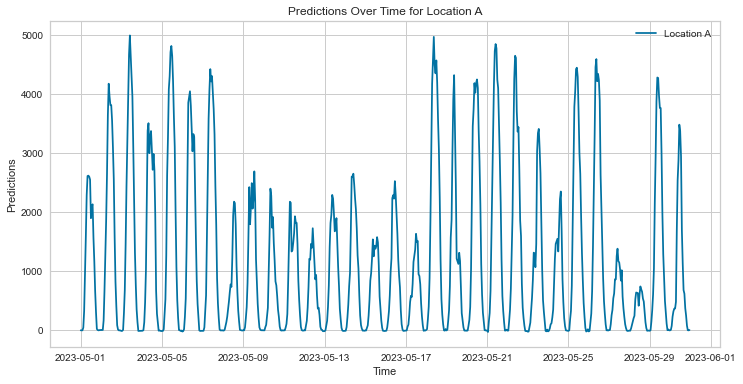

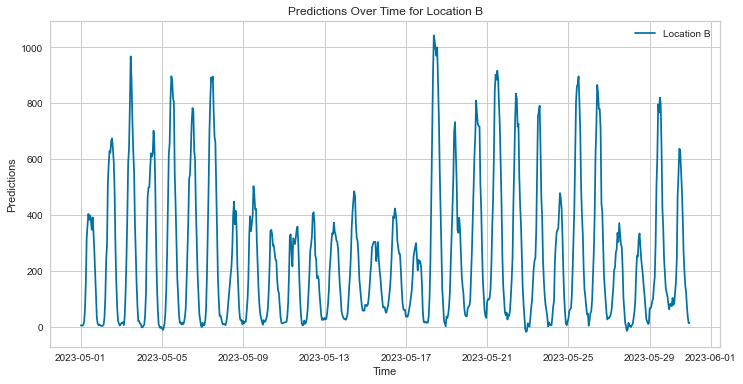

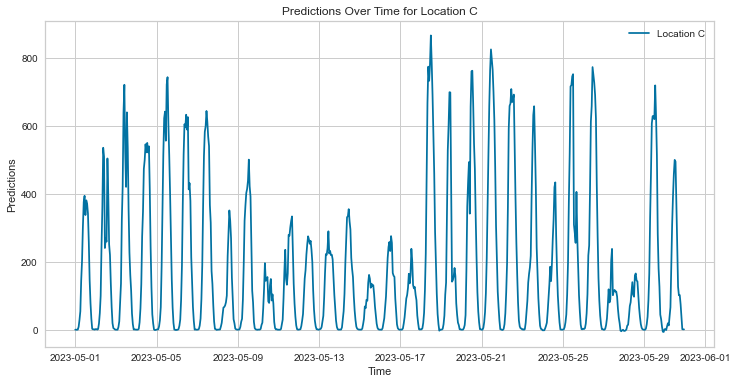

In [14]:
locations = ['A', 'B', 'C']
all_predictions = []
final_df_list = [] 


for loc in locations:
    # Load your data
    train = pd.read_parquet(f'{loc}/train_targets.parquet').fillna(0)
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    X_train_observed = pd.read_parquet(f'{loc}/X_train_observed.parquet')
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')

    # Preprocess data
    X_train, X_test = preprocessing(train, X_train_observed, X_train_estimated, X_test_estimated)
    y_train = train['pv_measurement'].values

    # Ensure X and y have the same length
    min_length = min(len(X_train), len(y_train))
    X_train, y_train = X_train.iloc[:min_length], y_train[:min_length]

    # Process the location data and get the final model
    final_model = process_location(X_train, y_train, loc)

    # Predict on new data
    predictions = predict_model(final_model, data=X_test)
    print(predictions.columns)

    # Store predictions
    all_predictions.append(predictions['prediction_label'])  

    # Prepare dataframe for visualization
    num_predictions = len(predictions)
    timestamps = pd.date_range(start='2023-05-01 00:00:00', periods=num_predictions, freq='H')

    df = pd.DataFrame({
        'time': timestamps,
        'prediction': predictions['prediction_label'],
        'location': loc
    })

    final_df_list.append(df)

# Concatenate all the individual data frames and prepare for plotting
final_df = pd.concat(final_df_list, ignore_index=True)
final_df['time'] = pd.to_datetime(final_df['time'])
final_df.sort_values('time', inplace=True)

# Visualization
for loc in locations:
    # Filter data for each location
    temp_df = final_df[final_df['location'] == loc]
    
    plt.figure(figsize=(12, 6))  # Create a new figure for each location
    plt.plot(temp_df['time'], temp_df['prediction'], label=f'Location {loc}')
    plt.xlabel('Time')
    plt.ylabel('Predictions')
    plt.title(f'Predictions Over Time for Location {loc}')
    plt.legend()
    plt.show()

# If you need to save the final dataframe without 'time' and 'location' columns, you can do so before plotting
final_df_save = final_df.copy()
final_df_save = final_df_save.drop(columns=['time', 'location'])

In [15]:
'''sample_submission = pd.read_csv('sample_submission.csv')
sample_submission
sample_submission = sample_submission[['id']].merge(final_df[['id', 'prediction']], on='id', how='left')
sample_submission.to_csv('my_first_submission.csv', index=False)'''

final_predictions = np.concatenate(all_predictions)

# Save the final_predictions to CSV
df = pd.DataFrame(final_predictions, columns=['prediction'])
df['id'] = df.index
df = df[['id', 'prediction']]
df.to_csv('final_predictions.csv', index=False)